In [ ]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from rankingFairness.src.experiment import simpleOffline
from rankingFairness.src.utils import set_seed, PlattCalibrator
from rankingFairness.src.experiment import simpleOffline
from rankingFairness.src.experimentMultipleGroups import simpleOfflineMultipleGroups
from rankingFairness.src.utils import set_seed
from rankingFairness.src.distributions import Bernoulli, Multinomial, Drichlet
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import pickle
import os.path as osp

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats
from sklearn.calibration import CalibratedClassifierCV

In [3]:
state="AL"
income_threshold=50000
group_name='RAC1P'
sim=10
num_groups=2
markers=['s', 'X', 'o', 'P']
labels_use=True

In [4]:
import folktables
from folktables import ACSDataSource, ACSEmployment, ACSEmploymentFiltered, ACSIncomePovertyRatio, ACSMobility
from folktables import ACSIncome, generate_categories

SEED=0
np.random.seed(SEED)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=[str(state)], download=True)
definition_df = data_source.get_definitions(download=True)
ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > income_threshold,    
    group=group_name,
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
features, labels, group_df = ACSIncome.df_to_pandas(acs_data, categories=categories, dummies=True)
label=labels.values.squeeze()
group = group_df.values.squeeze()

In [5]:
ACSIncome.features

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']

In [9]:
features.head()

,AGEP,WKHP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,COW_Working without pay in family business or farm,...,SEX_Male,RAC1P_Alaska Native alone,RAC1P_American Indian alone,"RAC1P_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",RAC1P_Asian alone,RAC1P_Black or African American alone,RAC1P_Native Hawaiian and Other Pacific Islander alone,RAC1P_Some Other Race alone,RAC1P_Two or More Races,RAC1P_White alone
0,18.0,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,53.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,18.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,21.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
def getTrainTestIdx(df, train_size=0.5):
    idxs = np.array(df.index)
    train_idxs = np.random.choice(idxs, size=int(len(idxs)*train_size), replace=False)
    test_idxs = np.setdiff1d(idxs, train_idxs)
    assert len(np.intersect1d(train_idxs, test_idxs))==0
    return train_idxs, test_idxs
train_idxs, test_idxs = getTrainTestIdx(features, 0.6)
test_idxs, val_idxs = getTrainTestIdx(features.iloc[test_idxs], 0.5)
assert len(np.intersect1d(train_idxs, test_idxs))==0
assert len(np.intersect1d(train_idxs, val_idxs))==0
assert len(np.intersect1d(val_idxs, test_idxs))==0
tr=len(train_idxs)
v=len(val_idxs)
t=len(test_idxs)
print(f"train %:{tr*100/(tr+v+t):.2f}, val %:{v*100/(tr+v+t):.2f}, test %:{t*100/(tr+v+t):.2f}")
print(f"total dataset:{tr+v+t}")

train %:60.00, val %:20.00, test %:20.00
total dataset:22268


In [11]:
def normalize_data(df,  train_idxs, columns_to_norm):
    """"Normalizes the data as Goel et al do - continuous features only"""
    
    df_unnormed_train = df.iloc[train_idxs].copy()
    for feature_name in columns_to_norm:
        df[feature_name] = df[feature_name] - np.mean(df_unnormed_train[feature_name])
        df[feature_name]  = df[feature_name] / np.std(df_unnormed_train[feature_name])
    return df

columns_to_norm = ['AGEP', 'WKHP']
features = normalize_data(features.copy(),  train_idxs, columns_to_norm)

In [12]:
features.head()

,AGEP,WKHP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,COW_Working without pay in family business or farm,...,SEX_Male,RAC1P_Alaska Native alone,RAC1P_American Indian alone,"RAC1P_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",RAC1P_Asian alone,RAC1P_Black or African American alone,RAC1P_Native Hawaiian and Other Pacific Islander alone,RAC1P_Some Other Race alone,RAC1P_Two or More Races,RAC1P_White alone
0,-1.649843,-1.382831,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.612715,0.116720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.163019,0.116720,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.649843,-2.882381,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.455909,0.905957,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
X_train=features.iloc[train_idxs].to_numpy()
X_val=features.iloc[val_idxs].to_numpy()
X_test=features.iloc[test_idxs].to_numpy()

y_train=label[train_idxs]
y_val=label[val_idxs]
y_test=label[test_idxs]

group_train=group[train_idxs]
group_val=group[val_idxs]
group_test=group[test_idxs]


In [16]:
def hypertune(model, params_dict, train_X, train_y, cv=5):
    """
    Given a dict of params distributions, do a randomized search
    with k-fold cross validation
    Args:
        model: base classifier
        params_dict: dict with distribution of each param
        train_X, train_y: train+val data 
    Returns:
        best params dict after randomized search cv with k-folds
    """
    model=RandomizedSearchCV(model, params_dict, random_state=0, scoring='neg_log_loss', cv=cv)
    search = model.fit(train_X, train_y)
    print(f"cv results:{search.cv_results_}")
    print(f"best score: {search.best_score_}")
    print(f" best params:{search.best_params_}")
    return search.best_params_

In [17]:

model = GradientBoostingClassifier(max_depth=5, loss='exponential', n_estimators=100, random_state=SEED)
model.fit(X_train, y_train)




GradientBoostingClassifier(loss='exponential', max_depth=5, random_state=0)

In [18]:
yhat = model.predict(X_test)
np.testing.assert_array_equal (np.unique(yhat), np.array([0, 1])), f"{np.unique(yhat)}"
yhat = yhat.astype(int)
y_test = y_test.astype(int)
np.testing.assert_array_equal (np.unique(y_test), np.array([0, 1])), f"{np.unique(y_test)}"
white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

print(f"total_accuracy:{len(yhat[yhat==y_test])/len(yhat)}")
yhat_white=yhat[group_test==1].astype(int)
yhat_black=yhat[group_test==2].astype(int)
y_test_white=y_test[group_test==1]
y_test_black=y_test[group_test==2]
print(f"{group_dict[1]} accuracy:{len(yhat_white[yhat_white==y_test_white])/len(yhat_white)}")
print(f"{group_dict[2]} accuracy:{len(yhat_black[yhat_black==y_test_black])/len(yhat_black)}")
# Equality of opportunity violation: 0.0871
print(f"EO violation:{group_dict[1]} tpr - {group_dict[2]} tpr:{white_tpr - black_tpr}")
print(f"DP violation:{np.mean(yhat_white)-np.mean(yhat_black)}")

total_accuracy:0.8022002694207454
White alone accuracy:0.7886672448684591
Black or African American alone accuracy:0.8541409147095179
EO violation:White alone tpr - Black or African American alone tpr:0.2887105155505434
DP violation:0.22117683719331271


In [20]:
if num_groups>2:
    yhat_asian=yhat[group_test==6].astype(int)
    y_test_asian=y_test[group_test==6]
    print(f"{group_dict[6]} accuracy:{len(yhat_asian[yhat_asian==y_test_asian])/len(yhat_asian)}")
    if num_groups==4:
        yhat_other=yhat[group_test==8].astype(int)
        y_test_other=y_test[group_test==8]
        print(f"{group_dict[8]} accuracy:{len(yhat_other[yhat_other==y_test_other])/len(yhat_other)}")

In [28]:
model

GradientBoostingClassifier(loss='exponential', max_depth=5, random_state=0)

In [29]:
y_prob_val = model.predict_proba(X_val)[:,1]

In [32]:
calibrated_clf = CalibratedClassifierCV(model, cv='prefit')
calibrated_clf.fit(X_val[group_val == 1], y_val[group_val == 1])
calibrated_clf.fit(X_val[group_val == 2], y_val[group_val == 2])
if num_groups>2:
    y_prob_asian=y_prob_val[group_val == 6]
    calibrated_clf.fit(X_val[group_val == 6], y_val[group_val == 6])
    if num_groups==4:
        y_prob_other=y_prob_val[group_val == 8]
        calibrated_clf.fit(X_val[group_val == 8], y_val[group_val == 8])

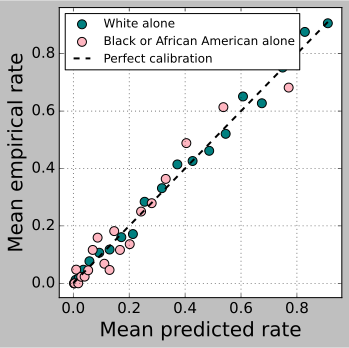

In [33]:
#After calibration
fig, ax =plt.subplots(figsize=(5,5))
offset=0.05
n_bins=20
# y_prob_white=platt.predict(model.predict_proba(X_val[group_val == 1])[:,1])
y_prob_white=calibrated_clf.predict_proba(X_val[group_val == 1])[:,1]
prob_true_white, prob_pred_white = calibration_curve(y_val[group_val == 1], y_prob_white , n_bins=n_bins, strategy='quantile')
ax.scatter(prob_pred_white, prob_true_white, s=80, c='teal', label=group_dict[1])

# y_prob_black=platt.predict(model.predict_proba(X_val[group_val == 2])[:,1])
y_prob_black=calibrated_clf.predict_proba(X_val[group_val == 2])[:,1]
prob_true_black, prob_pred_black = calibration_curve(y_val[group_val == 2], y_prob_black , n_bins=n_bins, strategy='quantile')
ax.scatter(prob_pred_black, prob_true_black, s=80, c='lightpink', label=group_dict[2])


axis_min=min(prob_true_white.min(), prob_pred_white.min(), prob_true_black.min(), prob_pred_black.min())
axis_max=max(prob_true_white.max(), prob_pred_white.max(), prob_true_black.max(), prob_pred_black.max())
ax.plot([axis_min, axis_max],[axis_min, axis_max],
        linestyle='--', color='black', linewidth=2, label="Perfect calibration")
ax.set_xlabel('Mean predicted rate', fontsize=20)
ax.set_ylabel('Mean empirical rate', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.legend( loc='upper left',markerscale=1., scatterpoints=1, fontsize=12)
ax.set_xlim(axis_min-offset, axis_max+offset)
ax.set_ylim(axis_min-offset, axis_max+offset)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

In [34]:
# save_path='/share/thorsten/rr568/CostOptimal_FairRankings/plots'
group_names=['White', 'Black', 'Asian', 'Others']

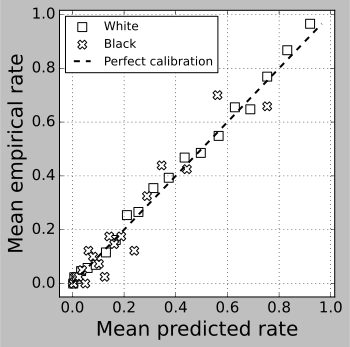

In [35]:
fig, ax =plt.subplots(figsize=(5,5))
offset=0.05
n_bins=20
# y_test_prob_white=platt.predict(model.predict_proba(X_test[group_test == 1])[:,1])
y_test_prob_white=calibrated_clf.predict_proba(X_test[group_test == 1])[:,1]
prob_true_white, prob_pred_white = calibration_curve(y_test[group_test == 1], y_test_prob_white , n_bins=n_bins, strategy='quantile')
ax.scatter(prob_pred_white, prob_true_white, s=80, marker=markers[0], facecolors='w',label=group_names[0])

# y_test_prob_black=platt.predict(model.predict_proba(X_test[group_test == 2])[:,1])
y_test_prob_black=calibrated_clf.predict_proba(X_test[group_test == 2])[:,1]
prob_true_black, prob_pred_black = calibration_curve(y_test[group_test == 2], y_test_prob_black , n_bins=n_bins, strategy='quantile')
ax.scatter(prob_pred_black, prob_true_black, s=80, marker=markers[1], facecolors='w', label=group_names[1])


axis_min=min(prob_true_white.min(), prob_pred_white.min(), prob_true_black.min(), prob_pred_black.min())
axis_max=max(prob_true_white.max(), prob_pred_white.max(), prob_true_black.max(), prob_pred_black.max())
ax.plot([axis_min, axis_max],[axis_min, axis_max],
        linestyle='--', color='black', linewidth=2, label="Perfect calibration")
ax.set_xlabel('Mean predicted rate', fontsize=20)
ax.set_ylabel('Mean empirical rate', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
legend = ax.legend( loc='upper left',markerscale=1., scatterpoints=1, fontsize=12)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0, 0, 1, 0.1))
ax.set_xlim(axis_min-offset, axis_max+offset)
ax.set_ylim(axis_min-offset, axis_max+offset)
plt.grid()
plt.tight_layout()
# plt.savefig(f"{osp.join(save_path, str(group_name), str(state), f'income_threshold_{income_threshold}_test_calibration_{num_groups}_groups.pdf')}")
plt.show()
plt.close()

In [36]:

if num_groups>2:
    fig, ax =plt.subplots(figsize=(5,5))
    offset=0.05
    n_bins=20

    y_test_prob_white=calibrated_clf.predict_proba(X_test[group_test == 1])[:,1]
    prob_true_white, prob_pred_white = calibration_curve(y_test[group_test == 1], y_test_prob_white , n_bins=n_bins, strategy='quantile')
    ax.scatter(prob_pred_white, prob_true_white, s=80, marker=markers[0], facecolors='w',label=group_names[0])

    y_test_prob_black=calibrated_clf.predict_proba(X_test[group_test == 2])[:,1]
    prob_true_black, prob_pred_black = calibration_curve(y_test[group_test == 2], y_test_prob_black , n_bins=n_bins, strategy='quantile')
    ax.scatter(prob_pred_black, prob_true_black, s=80, marker=markers[1], facecolors='w',label=group_names[1])

    y_test_prob_asian=calibrated_clf.predict_proba(X_test[group_test == 6])[:,1]
    prob_true_asian, prob_pred_asian = calibration_curve(y_test[group_test == 6], y_test_prob_asian , n_bins=n_bins, strategy='quantile')
    ax.scatter(prob_pred_asian, prob_true_asian, s=80, marker=markers[2], facecolors='w',label=group_names[2])
    
    axis_min=min(prob_true_asian.min(), prob_pred_asian.min(),
                 prob_true_white.min(), prob_pred_white.min(),
                 prob_true_black.min(), prob_pred_black.min())
    axis_max=max(prob_true_asian.max(), prob_pred_asian.max(),
                 prob_true_white.max(), prob_pred_white.max(),
                 prob_true_black.max(), prob_pred_black.max())
    if num_groups==4:
        y_test_prob_other=calibrated_clf.predict_proba(X_test[group_test == 8])[:,1]
        prob_true_other, prob_pred_other = calibration_curve(y_test[group_test == 8], y_test_prob_other , n_bins=n_bins, strategy='quantile')
        ax.scatter(prob_pred_other, prob_true_other, s=80, marker=markers[3], facecolors='w',label=group_names[3])
        axis_min=min(prob_true_asian.min(), prob_pred_asian.min(),
                 prob_true_white.min(), prob_pred_white.min(),
                 prob_true_black.min(), prob_pred_black.min(),
                 prob_true_other.min(), prob_pred_other.min())
        axis_max=max(prob_true_asian.max(), prob_pred_asian.max(),
                 prob_true_white.max(), prob_pred_white.max(),
                 prob_true_black.max(), prob_pred_black.max(),
                 prob_true_other.max(), prob_pred_other.max())
    ax.plot([axis_min, axis_max],[axis_min, axis_max],
            linestyle='--', color='black', linewidth=2, label="Perfect calibration")
    ax.set_xlabel('Mean predicted rate', fontsize=20)
    ax.set_ylabel('Mean empirical rate', fontsize=20)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    legend = ax.legend( loc='upper left',markerscale=1., scatterpoints=1, fontsize=12)
#     legend.get_frame().set_alpha(None)
#     legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    ax.set_xlim(axis_min-offset, axis_max+offset)
    ax.set_ylim(axis_min-offset, axis_max+offset)
    plt.grid()
    plt.tight_layout()
#     plt.savefig(f"{osp.join(save_path, str(group_name), str(state), f'income_threshold_{income_threshold}_test_calibration_{num_groups}_groups.pdf')}")
    plt.show()
    plt.close()

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
plt.hist(y_test_prob_white, label=group_dict[1], bins=50, alpha=0.5)
plt.hist(y_test_prob_black, label=group_dict[2], bins=50, alpha=0.5)
if num_groups>2:
    plt.hist(y_test_prob_asian, label=group_dict[6], bins=50, alpha=0.5)
    if num_groups==4:
        plt.hist(y_test_prob_other, label=group_dict[8], bins=50, alpha=0.5)
plt.legend()
plt.xlabel(r'Calibrated $\mathbb{P}(r_i|\mathbb{D})$', fontsize=15)
plt.ylabel(r'Counts', fontsize=15)
plt.tight_layout()
plt.savefig(f"{osp.join(save_path, str(group_name), str(state), f'income_threshold_{income_threshold}_test_calibrated_probs_{num_groups}_groups.pdf')}")
plt.show()
plt.close()

In [ ]:
for i in range(1,10):
    print("Train \n")
    print(f" race:{group_dict[i]}, len:{len(X_train[group_train == i])}")
    print("Val \n")
    print(f" race:{group_dict[i]}, len:{len(X_val[group_val == i])}")
    print("test \n")
    print(f" race:{group_dict[i]}, len:{len(X_test[group_test == i])}")

In [ ]:
print(f" sum white probs:{y_test_prob_white.sum()},sum black probs:{y_test_prob_black.sum()}")
if num_groups>2:
    print(f" sum asian probs: {y_test_prob_asian.sum()}")
    if num_groups==4:
        print(f" sum other race probs:{y_test_prob_other.sum()}")

In [ ]:
if num_groups==2:
    from rankingFairness.src.rankingsMultipleGroups import PRP_Ranker, EO_RankerII, TS_RankerII, DP_Ranker, Uniform_Ranker
    rankingAlgos=[PRP_Ranker, EO_RankerII, TS_RankerII, DP_Ranker, Uniform_Ranker]
    A_true = y_test_prob_white
    B_true = y_test_prob_black

    A_dist = [Bernoulli(p) for p in A_true]
    B_dist = [Bernoulli(p) for p in B_true]

    merits_white = y_test[group_test==1].astype(float)
    merits_black = y_test[group_test==2].astype(float)
    merits = np.hstack((merits_white, merits_black))[None,:]

    assert merits.shape[0]==1
    assert merits.shape[1]==len(A_dist)+len(B_dist)
    num_docs=len(A_true)+len(B_true)

    if labels_use:
        exp = simpleOfflineMultipleGroups(num_groups=num_groups, num_docs=num_docs, 
            predfined_ls=[A_dist, B_dist], distType=BetaBernoulli, switch_start=False, merits=merits, verbose=True,
            saveFig=osp.join(save_path, str(group_name), str(state), f"labels_{labels_use}_income_threshold_{income_threshold}_{num_groups}_groups"))
    else:
        exp = simpleOfflineMultipleGroups(num_groups=num_groups, num_docs=num_docs, 
            predfined_ls=[A_dist, B_dist], distType=BetaBernoulli, switch_start=False, verbose=True,
            saveFig=osp.join(save_path, str(group_name), str(state), f"labels_{labels_use}_income_threshold_{income_threshold}_{num_groups}_groups"))
    exp.experiment(rankingAlgos=rankingAlgos, simulations=sim)